# HERMES calculation in the Full Sky


###  time of the calculation: $\mathrm{nside}=32 \; \rightarrow \; t \sim 1 \, \mathrm{hr}$

In [1]:
from pyhermes import *
from pyhermes.units import *
import astropy.units as u
import astropy.io.fits as pyfits
import numpy as np
import healpy
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as tick
import matplotlib.colors as colors
from matplotlib import cm
import time

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1

# <center> Chosen resolution

### $\bullet \quad$ Number of the pixels in the map
### $\bullet \quad$ Number of the pixels where we compute the integral along the LOS

$$
\begin{aligned}
& \\
&\mathrm{nside} = 2^{\mathrm{res}} \\
&\mathrm{npix} = 12 \cdot \mathrm{nside}^2
\end{aligned}
$$

In [3]:
### Block to select the resolution of the run ###


nside = 512
sun_pos = Vector3QLength(8.0*kpc, 0*pc, 0*pc)
conv_joule_GeV = 6.242e+9

resol = healpy.nside2resol(nside, arcmin = False)
npix = healpy.nside2npix(nside)

print('number of pixels in the map:', npix)
print('resolution:', np.degrees(resol), '[deg]')

number of pixels in the map: 3145728
resolution: 0.11451621372724687 [deg]


In [4]:
### Block to dissect the DRAGON run ###


filename = '/home/ottavio/DRAGON2-Beta_version/output/BaseModel_DRAGONxsec.fits.gz'


# Hadron section #
# CR distribution
dragon2D_proton = cosmicrays.Dragon2D(filename, [Proton])
dragon2D_helium = cosmicrays.Dragon2D(filename, [Helium])
cr_list = [dragon2D_proton, dragon2D_helium]

# cross-sections
kamae_crosssection = interactions.Kamae06Gamma()
brems_crosssection = interactions.BremsstrahlungTsai74()

# distribution of the targets
neutral_gas_HI = neutralgas.RingModel(neutralgas.GasType.HI)
neutral_gas_H2 = neutralgas.RingModel(neutralgas.GasType.H2)



# Lepton section #
# CR distribution
dragon2D_leptons = cosmicrays.Dragon2D([Electron, Positron])

# cross-sections
kn_crosssection = interactions.KleinNishina()

# distribution of the targets
CMB_photons = photonfields.CMB()
ISRF_photons = photonfields.ISRF()

In [5]:
### Block to define the integrators ###


# Hadron section #
integratorHI = PiZeroIntegrator(cr_list, neutral_gas_HI, kamae_crosssection)
integratorH2 = PiZeroIntegrator(cr_list, neutral_gas_H2, kamae_crosssection)
integratorBremsHI = BremsstrahlungIntegrator(dragon2D_leptons, neutral_gas_HI, brems_crosssection)
integratorBremsH2 = BremsstrahlungIntegrator(dragon2D_leptons, neutral_gas_H2, brems_crosssection)

integratorHI.setupCacheTable(120, 120, 24)    # nx,ny,nz
integratorHI.setObsPosition(sun_pos)
integratorH2.setupCacheTable(120, 120, 24)
integratorH2.setObsPosition(sun_pos)
integratorH2.setupCacheTable(120, 120, 24)
integratorBremsHI.setupCacheTable(120, 120, 24)
integratorBremsHI.setObsPosition(sun_pos)
integratorBremsH2.setupCacheTable(120, 120, 24)
integratorBremsH2.setObsPosition(sun_pos)



# Lepton section #
integratorIC_cmb  = InverseComptonIntegrator(dragon2D_leptons, CMB_photons, kn_crosssection)
integratorIC_isrf = InverseComptonIntegrator(dragon2D_leptons, ISRF_photons, kn_crosssection)

integratorIC_cmb.setupCacheTable(30, 30, 12)
integratorIC_cmb.setObsPosition(sun_pos)
integratorIC_isrf.setupCacheTable(30, 30, 12)
integratorIC_isrf.setObsPosition(sun_pos)

# <center> How to find the definition of a function
### <center> Example: RectangularWindow()
    
### $\bullet \quad$ grep -r 'RectangularWindow'
### $\bullet \quad$ look for the file with .cpp extension (C++)
### $\Longrightarrow \quad$ SkymapMask.cpp, line 63
    
    RectangularWindow::RectangularWindow(const std::array<QAngle, 2> &latitude, 
                                         const std::array<QAngle, 2> &longitude)

In [6]:
### Block to build the Skymap containers ###


# Full-sky exploration
mask_edges = ([-90*deg, 90*deg], [0*deg, 360*deg])
mask = RectangularWindow(*mask_edges)

En_points = 12



# Hadron section #
print("building SkyMapRange object for pi0")
skymapHI_range = GammaSkymapRange(nside, 10.*GeV, 10.*TeV, En_points)
skymapH2_range = GammaSkymapRange(nside, 10.*GeV, 10.*TeV, En_points)
print('')

print("building SkyMapRange object for Brems")
skymapBremsHI_range = GammaSkymapRange(nside, 10.*GeV, 10.*TeV, En_points)
skymapBremsH2_range = GammaSkymapRange(nside, 10.*GeV, 10.*TeV, En_points)
print('')

skymapHI_range.setMask(mask)
skymapH2_range.setMask(mask)
skymapBremsHI_range.setMask(mask)
skymapBremsH2_range.setMask(mask)



# Lepton section #
print("building SkyMapRange object for IC")
skymapIC_cmb_range = GammaSkymapRange(nside, 10.*GeV, 10.*TeV, En_points)
skymapIC_isrf_range = GammaSkymapRange(nside, 10.*GeV, 10.*TeV, En_points)

skymapIC_cmb_range.setMask(mask)
skymapIC_isrf_range.setMask(mask)

building SkyMapRange object for pi0

building SkyMapRange object for Brems

building SkyMapRange object for IC


In [7]:
SkyMapsOutputsFolder = '/home/ottavio/.virtualenvs/Hermes_Output/'

In [8]:
### Block to calculate the Skymaps ###


start = time.perf_counter()


print("Starting calculation of skymaps... ")
print('')
print('')


# Hadron section #

# Calculation of HI skymap
skymapHI_range.setIntegrator(integratorHI)
skymapHI_range.compute()
nameHI = SkyMapsOutputsFolder + 'BaseRunHI_nside' + str(nside)
skymapHI_range.save(outputs.HEALPixFormat("!{}.fits.gz".format(nameHI)))
print("pi0 HI done")
print('')

# Calculation of H2 skymap
skymapH2_range.setIntegrator(integratorH2)
skymapH2_range.compute()
nameH2 = SkyMapsOutputsFolder + 'BaseRunH2_nside' + str(nside)
skymapH2_range.save(outputs.HEALPixFormat("!{}.fits.gz".format(nameH2)))
print("pi0 H2 done")
print('')


# Calculation of Brems HI skymap
skymapBremsHI_range.setIntegrator(integratorBremsHI)
skymapBremsHI_range.compute()
nameBremsHI = SkyMapsOutputsFolder + 'BaseRunBremsHI_nside' + str(nside)
skymapBremsHI_range.save(outputs.HEALPixFormat("!{}.fits.gz".format(nameBremsHI)))
print("Brems on H2 done")
print('')

# Calculation of Brems H2 skymap
skymapBremsH2_range.setIntegrator(integratorBremsH2)
skymapBremsH2_range.compute()
nameBremsH2 = SkyMapsOutputsFolder + 'BaseRunBremsH2_nside' + str(nside)
skymapBremsH2_range.save(outputs.HEALPixFormat("!{}.fits.gz".format(nameBremsH2)))
print("Brems on HI done")
print('')





# Lepton section #

# Calculation of IC skymap (CMB)
skymapIC_cmb_range.setIntegrator(integratorIC_cmb)
skymapIC_cmb_range.compute()
nameIC1 = SkyMapsOutputsFolder + 'BaseRunIC_cmb_nside' + str(nside)
skymapIC_cmb_range.save(outputs.HEALPixFormat("!{}.fits.gz".format(nameIC1)))
print("IC on CMB done")
print('')

# Calculation of IC skymap (ISRF)
skymapIC_isrf_range.setIntegrator(integratorIC_isrf)
skymapIC_isrf_range.compute()
nameIC2 = SkyMapsOutputsFolder + 'BaseRunIC_isrf_nside' + str(nside)
skymapIC_isrf_range.save(outputs.HEALPixFormat("!{}.fits.gz".format(nameIC2)))
print("IC on ISRF done")
print('')



print('')
print('Total time:', time.perf_counter() - start, "seconds")

Starting calculation of skymaps... 


pi0 HI done

pi0 H2 done

Brems on H2 done

Brems on HI done

IC on CMB done

IC on ISRF done


Total time: 68525.819950726 seconds


In [9]:
### Path to the HERMES output ###

SkyMapsFolder = SkyMapsOutputsFolder + 'Sky_Maps/'

In [10]:
### Block to choose the energy at which we visualize the maps ###


reference_energy = 10.*GeV      # the energy is expressed in SI units, here [Joule]


energy_vector = np.asarray([s.getEnergy() for s in skymapHI_range])
index = np.argmin(np.abs(energy_vector - reference_energy))

print("We are going to visualize the maps at E =", energy_vector[index]/GeV, 'GeV')

We are going to visualize the maps at E = 10.0 GeV


n_ext_HI: 13 ; must be equal to len(E)+1 = 13

First HDU Header: SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   32 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H DATE    = '2021-06-18T20:19:27' / file creation date (YYYY-MM-DDThh:mm:ss UT)   SOFTWARE= 'HERMES  '           / Created by Hermes, cosmicrays.github.io/hermes VERSION = 'v1.0.0-2-gb75233c2' / Hermes ver. [GIT_DESC]                         END                                                                                                                                                                                                                    

<ipython-input-11-f3deecd76233>:41: RuntimeWarning: divide by zero encountered in log10
  healpy.mollview(np.log10(np.abs(HI_map)), coord = "G", title=r"$\pi^0$ from HI, E = " + str(reference_energy/GeV) + ' GeV', unit = '$\mathrm{GeV^{-1} \, cm^{-2} \, s^{-1} \, sr^{-1}}$',
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWa

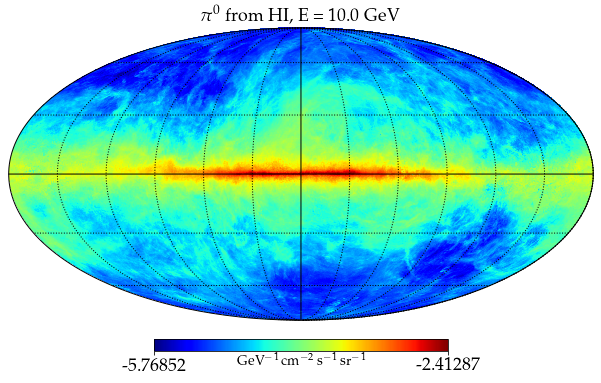

In [11]:
### Plot the mollview map for pi0-decay due to atomic hydrogen (HI) ###



# Look at the FITS file created by HERMES #
HI_hdulist = pyfits.open(SkyMapsOutputsFolder + 'BaseRunHI_nside' + str(nside) + '.fits.gz')

n_ext_HI = len(HI_hdulist)
print('n_ext_HI:', n_ext_HI, '; must be equal to len(E)+1 =', En_points + 1)
print('')

first_hdu_HI = HI_hdulist[0]
first_hdu_header_HI = first_hdu_HI.header

print('First HDU Header:', first_hdu_header_HI)
print('')
print('index + 1:', index+1)
print('')

current_hdu = HI_hdulist[index+1]
current_header = current_hdu.header
print('current_header:', current_header)
print('')

nside = current_header['NSIDE']
npix = healpy.nside2npix(nside)

print('nside:', nside)
print('npix:', npix)
print('')

HI_map = np.zeros(npix)         # we assign a gamma-ray flux to each pixels 
HI_map_data = np.array(current_hdu.data)
HI_map[:] = HI_map_data[:]
print('HI_map.shape:', HI_map.shape)



# Plotting section #
plt.rcParams.update({'font.size': 15})
healpy.mollview(np.log10(np.abs(HI_map)), coord = "G", title=r"$\pi^0$ from HI, E = " + str(reference_energy/GeV) + ' GeV', unit = '$\mathrm{GeV^{-1} \, cm^{-2} \, s^{-1} \, sr^{-1}}$',
                     xsize = 3600, notext = 'True', cbar = True, cmap='jet')
healpy.graticule()



plt.savefig(SkyMapsFolder + 'Pi0_mollview_HI_nside=' + str(nside) + '_E=' + str(reference_energy/GeV) + 'GeV.pdf', dpi=300)

n_ext_H2: 13 ; must be equal to len(E)+1 = 13

First HDU Header: SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   32 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H DATE    = '2021-06-19T00:23:22' / file creation date (YYYY-MM-DDThh:mm:ss UT)   SOFTWARE= 'HERMES  '           / Created by Hermes, cosmicrays.github.io/hermes VERSION = 'v1.0.0-2-gb75233c2' / Hermes ver. [GIT_DESC]                         END                                                                                                                                                                                                                    

<ipython-input-12-734a23a05672>:41: RuntimeWarning: divide by zero encountered in log10
  healpy.mollview(np.log10(H2_map), coord = "G", title=r"$\pi^0$ from $H_2$, E = " + str(reference_energy/GeV) + ' GeV', unit = '',
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.


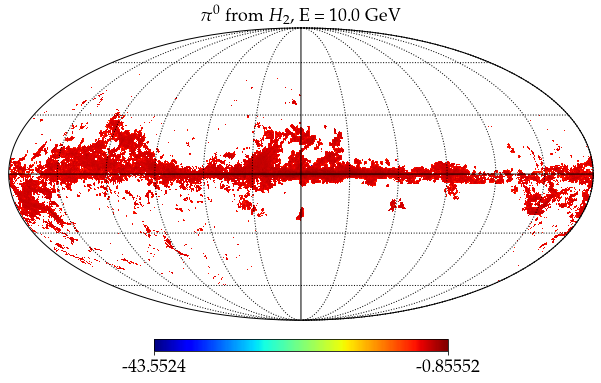

In [12]:
### Plot the mollview map for pi0-decay due to molecular hydrogen (H2) ###



# Look at the FITS file created by HERMES #
H2_hdulist = pyfits.open(SkyMapsOutputsFolder + 'BaseRunH2_nside' + str(nside) + '.fits.gz')

n_ext_H2 = len(H2_hdulist)
print('n_ext_H2:', n_ext_H2, '; must be equal to len(E)+1 =', En_points + 1)
print('')

first_hdu_H2 = H2_hdulist[0]
first_hdu_header_H2 = first_hdu_H2.header

print('First HDU Header:', first_hdu_header_H2)
print('')
print('index + 1:', index+1)
print('')

current_hdu = H2_hdulist[index+1]
current_header = current_hdu.header
print('current_header:', current_header)
print('')

nside = current_header['NSIDE']
npix = healpy.nside2npix(nside)

print('nside:', nside)
print('npix:', npix)
print('')

H2_map = np.zeros(npix)
H2_map_data = np.array(current_hdu.data)
H2_map[:] = H2_map_data[:]
print('H2_map.shape:', H2_map.shape)



# Plotting section #
plt.rcParams.update({'font.size': 15})
healpy.mollview(np.log10(H2_map), coord = "G", title=r"$\pi^0$ from $H_2$, E = " + str(reference_energy/GeV) + ' GeV', unit = '',
                     xsize = 3600, notext = 'True', cbar = True, cmap='jet')
healpy.graticule()



plt.savefig(SkyMapsFolder + 'Pi0_mollview_H2_nside=' + str(nside) + '_E=' + str(reference_energy/GeV) + 'GeV.pdf', dpi=300)

n_ext_HI_Brems: 13 ; must be equal to len(E)+1 = 13

First HDU Header: SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   32 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H DATE    = '2021-06-19T04:47:03' / file creation date (YYYY-MM-DDThh:mm:ss UT)   SOFTWARE= 'HERMES  '           / Created by Hermes, cosmicrays.github.io/hermes VERSION = 'v1.0.0-2-gb75233c2' / Hermes ver. [GIT_DESC]                         END                                                                                                                                                                                                              

<ipython-input-13-3b49f4e6fe21>:42: RuntimeWarning: divide by zero encountered in log10
  healpy.mollview(np.log10(HI_Brems_map), coord = "G", title=r"Bremsstrahlung from HI, E = " + str(reference_energy/GeV) + ' GeV', unit = '',
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 de

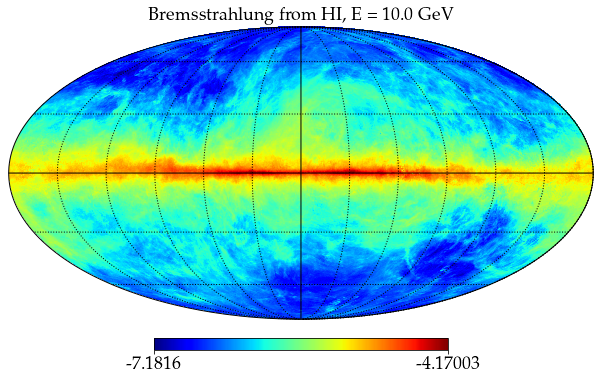

In [13]:
### Plot the mollview map for bremsstrahlung due to HI ###



# Look at the FITS file created by HERMES #
HIBrems_hdulist = pyfits.open(SkyMapsOutputsFolder + 'BaseRunBremsHI_nside' + str(nside) + '.fits.gz')


n_ext_HI_Brems = len(HIBrems_hdulist)
print('n_ext_HI_Brems:', n_ext_HI_Brems, '; must be equal to len(E)+1 =', En_points + 1)
print('')

first_hdu_HI_Brems = HIBrems_hdulist[0]
first_hdu_header_HI_Brems = first_hdu_HI_Brems.header

print('First HDU Header:', first_hdu_header_HI_Brems)
print('')
print('index + 1:', index+1)
print('')

current_hdu_Brems = HIBrems_hdulist[index+1]
current_header_Brems = current_hdu_Brems.header
print('current_header:', current_header_Brems)
print('')

nside = current_header_Brems['NSIDE']
npix = healpy.nside2npix(nside)

print('nside:', nside)
print('npix:', npix)
print('')

HI_Brems_map = np.zeros(npix)
HI_Brems_map_data = np.array(current_hdu_Brems.data)
HI_Brems_map[:] = HI_Brems_map_data[:]
print('HI_Brems_map.shape:', HI_Brems_map.shape)



# Plotting section #
plt.rcParams.update({'font.size': 15})
healpy.mollview(np.log10(HI_Brems_map), coord = "G", title=r"Bremsstrahlung from HI, E = " + str(reference_energy/GeV) + ' GeV', unit = '',
                     xsize = 3600, notext = 'True', cbar = True, cmap='jet')#, norm='log')
healpy.graticule()



plt.savefig(SkyMapsFolder + 'Bremsstrahlung_mollview_HI_nside=' + str(nside) + '_E=' + str(reference_energy/GeV) + 'GeV.pdf', dpi=300)

n_ext_H2_Brems: 13 ; must be equal to len(E)+1 = 13

First HDU Header: SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   32 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H DATE    = '2021-06-19T08:53:03' / file creation date (YYYY-MM-DDThh:mm:ss UT)   SOFTWARE= 'HERMES  '           / Created by Hermes, cosmicrays.github.io/hermes VERSION = 'v1.0.0-2-gb75233c2' / Hermes ver. [GIT_DESC]                         END                                                                                                                                                                                                              

<ipython-input-14-3198257403cb>:42: RuntimeWarning: divide by zero encountered in log10
  healpy.mollview(np.log10(H2_Brems_map), coord = "G", title=r"Bremsstrahlung from $H_2$, E = " + str(reference_energy/GeV) + ' GeV', unit = '',


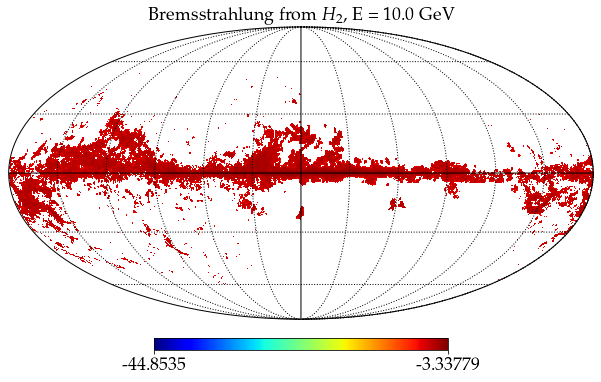

In [14]:
### Plot the mollview map for bremsstrahlung due to H2 ###



# Look at the FITS file created by HERMES #
H2Brems_hdulist = pyfits.open(SkyMapsOutputsFolder + 'BaseRunBremsH2_nside' + str(nside) + '.fits.gz')


n_ext_H2_Brems = len(H2Brems_hdulist)
print('n_ext_H2_Brems:', n_ext_H2_Brems, '; must be equal to len(E)+1 =', En_points + 1)
print('')

first_hdu_H2_Brems = H2Brems_hdulist[0]
first_hdu_header_H2_Brems = first_hdu_H2_Brems.header

print('First HDU Header:', first_hdu_header_H2_Brems)
print('')
print('index + 1:', index+1)
print('')

current_hdu_Brems = H2Brems_hdulist[index+1]
current_header_Brems = current_hdu_Brems.header
print('current_header:', current_header_Brems)
print('')

nside = current_header_Brems['NSIDE']
npix = healpy.nside2npix(nside)

print('nside:', nside)
print('npix:', npix)
print('')

H2_Brems_map = np.zeros(npix)
H2_Brems_map_data = np.array(current_hdu_Brems.data)
H2_Brems_map[:] = H2_Brems_map_data[:]
print('H2_Brems_map.shape:', H2_Brems_map.shape)



# Plotting section #
plt.rcParams.update({'font.size': 15})
healpy.mollview(np.log10(H2_Brems_map), coord = "G", title=r"Bremsstrahlung from $H_2$, E = " + str(reference_energy/GeV) + ' GeV', unit = '',
                     xsize = 3600, notext = 'True', cbar = True, cmap='jet')
healpy.graticule()



plt.savefig(SkyMapsFolder + 'Bremsstrahlung_mollview_H2_nside=' + str(nside) + '_E=' + str(reference_energy/GeV) + 'GeV.pdf', dpi=300)

first_hdu_header_IC: SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   32 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H DATE    = '2021-06-19T10:53:10' / file creation date (YYYY-MM-DDThh:mm:ss UT)   SOFTWARE= 'HERMES  '           / Created by Hermes, cosmicrays.github.io/hermes VERSION = 'v1.0.0-2-gb75233c2' / Hermes ver. [GIT_DESC]                         END                                                                                                                                                                                                                                                                

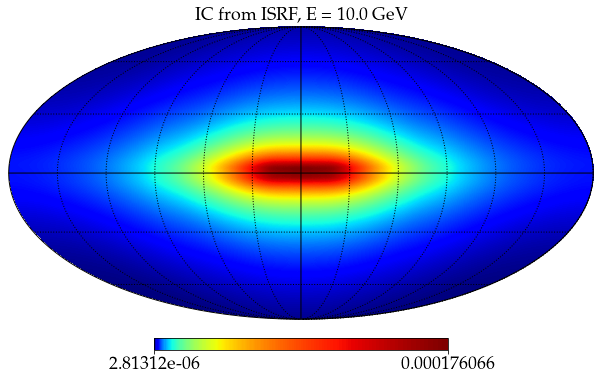

In [15]:
### Plot the Inverse-Compton mollview map ###



# Look at the FITS file created by HERMES #
IC_hdulist = pyfits.open(SkyMapsOutputsFolder + 'BaseRunIC_isrf_nside' + str(nside) + '.fits.gz')


n_ext_IC = len(IC_hdulist)

first_hdu_IC = IC_hdulist[0]
first_hdu_header_IC = first_hdu_IC.header
print('first_hdu_header_IC:', first_hdu_header_IC)
print('index + 1:', index+1)
print('')


current_hdu = IC_hdulist[index+1]
current_header = current_hdu.header
print('current_header:', current_header)
print('')

nside = current_header['NSIDE']
npix = healpy.nside2npix(nside)
print('nside:', nside)
print('npix:', npix)
print('')

IC_map = np.zeros(npix)
IC_map_data = np.array(current_hdu.data)
IC_map[:] = IC_map_data[:]
print('IC_map.shape:', IC_map.shape)
print('')



# Plotting section #
plt.rcParams.update({'font.size': 15})
healpy.mollview(IC_map, coord = "G", title=r"IC from ISRF, E = " + str(reference_energy/GeV) + ' GeV', unit = '',
                     norm = 'log', xsize = 3600, notext = 'True', cbar = True, cmap='jet')
healpy.graticule()



plt.savefig(SkyMapsFolder + 'IC_mollview_isrf_nside=' + str(nside) + '_E=' + str(reference_energy/GeV) + 'GeV.pdf', dpi=300)

## <center> Galactic coordinates in a cartesian frame
    
$$
\begin{aligned}
&b \in [-90^\circ, \, 90^\circ] \quad \rightarrow \theta \in [0^\circ, \, 180^\circ] \\
&l \in [0^\circ, \, 360^\circ] \quad \rightarrow \phi \in [0^\circ, \, 360^\circ]
\end{aligned}
$$

number of pixels: 3145728
pixels along x: 2508
pixels along y: 1254


<ipython-input-16-6731d9e0ba49>:49: RuntimeWarning: divide by zero encountered in log10
  image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)
<ipython-input-16-6731d9e0ba49>:49: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)


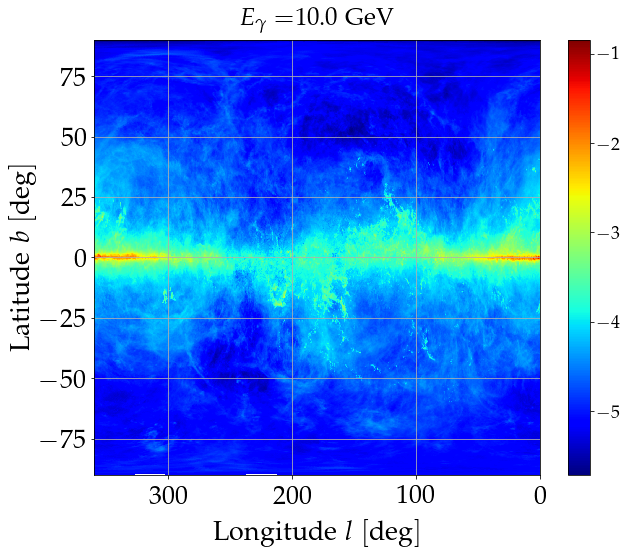

In [16]:
### Cartesian map at given reference energy ###



fig = plt.figure(figsize=[10,8])

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7


cmap = "jet"


# Full-sky coordinates
b_min = -90.
b_max = 90.
l_min = 0.
l_max = 360.


theta_min = np.pi/2. - np.radians(b_min)
theta_max = np.pi/2. - np.radians(b_max)
phi_min = np.radians(l_min)
phi_max = np.radians(l_max)


numpix = healpy.nside2npix(nside)
xsize = int(np.sqrt((l_max-l_min)/(b_max-b_min)*numpix))   # fraction of the pixel-per-side number assigned to this range
ysize = int((b_max-b_min)/(l_max-l_min)*xsize)
print('number of pixels:', numpix)
print('pixels along x:', xsize)
print('pixels along y:', ysize)


b = np.linspace(b_min, b_max, ysize)
l = np.linspace(l_min, l_max, xsize)
theta = np.linspace(theta_min, theta_max, ysize)
phi = np.linspace(phi_min, phi_max, xsize)


PHI, THETA = np.meshgrid(phi, theta)
grid_pix = healpy.ang2pix(nside, THETA, PHI)
grid_map = HI_map[grid_pix] + H2_map[grid_pix]


image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)
cbar = plt.colorbar(image)


plt.grid(True)
plt.title('$E_{\gamma} =$' + str(reference_energy/GeV) + ' GeV', fontsize=25, pad=15)


# Plot the longitudinal axis inverted
ax.set_xlim(l_max, l_min)
ax.set_xlabel(r'${\rm Longitude} \; l \; {\rm [deg]}$', fontsize=27, color='k')
ax.set_ylabel(r'${\rm Latitude} \; b \; {\rm [deg]}$', fontsize=27, color='k')


plt.savefig(SkyMapsFolder + 'Pi0_FullSky_cartesian_nside=' + str(nside) + '_E=' + str(reference_energy/GeV) + 'GeV.pdf', dpi=300)  

number of pixels: 3145728
xsize: 2508
ysize 1254

min l: 0.0 , max l: 360.0 in [deg]

min l: 0.0 , max l: 6.283185307179586 in [rad]

l shape: (2508,)
l: [ 3.14033953  3.13783327  3.13532701 ... -3.13532701 -3.13783327
 -3.14033953]


<ipython-input-17-7f862fc3782d>:88: RuntimeWarning: divide by zero encountered in log10
  image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)
<ipython-input-17-7f862fc3782d>:88: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)


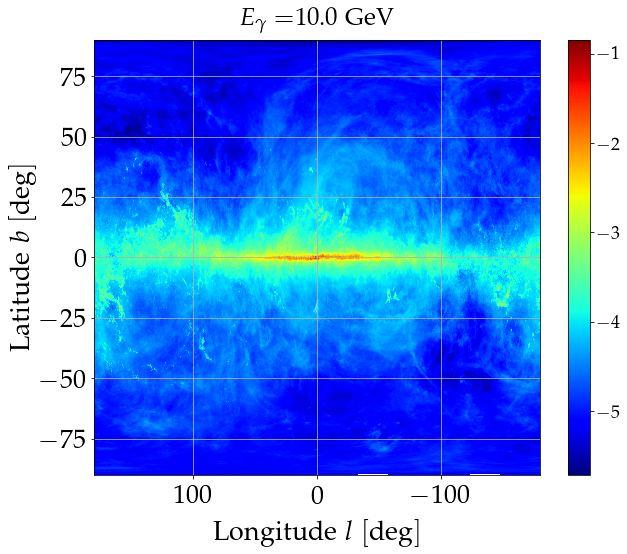

In [17]:
### Cartesian map at given reference energy ###
## Here we want to obtain the Galactic Center at the center of the plot ##



fig = plt.figure(figsize=[10,8])

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7


cmap = "jet"


# Full-sky coordinates
b_min = -90.
b_max = 90.
l_min = 0.
l_max = 360.


theta_min = np.pi/2. - np.radians(b_min)
theta_max = np.pi/2. - np.radians(b_max)
phi_min = np.radians(l_min)
phi_max = np.radians(l_max)


numpix = healpy.nside2npix(nside)
xsize = int(np.sqrt((l_max-l_min)/(b_max-b_min)*numpix))
ysize = int((b_max-b_min)/(l_max-l_min)*xsize)
print('number of pixels:', numpix)
print('xsize:', xsize)
print('ysize', ysize)
print('')


b = np.linspace(b_min, b_max, ysize)
l = np.linspace(l_min, l_max, xsize)


print('min l:', min(l), ', max l:', max(l), 'in [deg]')
print('')

# convert l into radians
l = [l[i]/180.*np.pi for i in range(len(l))]

print('min l:', min(l), ', max l:', max(l), 'in [rad]')
print('')



l_temp_left = []
l_temp_right = []
l_temp_left_rev = []
l_temp_right_rev = []
l_list = []
for i in range(len(l)):
    
    if ( l[i] <= np.pi ):
        l_temp_left.append(l[i])
    
    elif ( l[i] > np.pi ):
        l_temp_right.append(l[i] - 2.*np.pi)
        
l_temp_left_rev = l_temp_left[::-1]     # reverse the list
l_temp_right_rev = l_temp_right[::-1]
l_list = l_temp_left_rev + l_temp_right_rev
l = np.asarray(l_list)

print('l shape:', l.shape)
print('l:', l)



theta = np.linspace(theta_min, theta_max, ysize)
PHI, THETA = np.meshgrid(l, theta)
grid_pix = healpy.ang2pix(nside, THETA, PHI)
grid_map = HI_map[grid_pix] + H2_map[grid_pix]


# re-convert l into degrees, only for visualization purposes
l = [l[i]*180./np.pi for i in range(len(l))]


image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)
cbar = plt.colorbar(image)


plt.grid(True)
plt.title('$E_{\gamma} =$' + str(reference_energy/GeV) + ' GeV', fontsize=25, pad=15)


# Plot the longitudinal axis inverted
ax.set_xlim(np.max(l), np.min(l))
ax.set_xlabel(r'${\rm Longitude} \; l \; {\rm [deg]}$', fontsize=27, color='k')
ax.set_ylabel(r'${\rm Latitude} \; b \; {\rm [deg]}$', fontsize=27, color='k')


plt.savefig(SkyMapsFolder + 'Pi0_FullSky_cartesian_GC-at-0_nside=' + str(nside) + '_E=' + str(reference_energy/GeV) + 'GeV.pdf', dpi=300)

n_ext_HI: 13 ; must be equal to len(E)+1 = 13
n_ext_H2: 13 ; must be equal to len(E)+1 = 13

nside = 512

npix: 3145728
xsize: 2508
ysize: 1254

Delta b / Delta l: 0.5
Delta l / Delta b: 2.0

current energy: 10.000785631854 GeV

current energy: 18.739646359259797 GeV

current energy: 35.114675846223236 GeV

current energy: 65.7984913987475 GeV

current energy: 123.29435958090242 GeV

current energy: 231.0311191231085 GeV

current energy: 432.91013623581404 GeV

current energy: 811.1945558115287 GeV

current energy: 1520.030492009137 GeV

current energy: 2848.2596192057613 GeV

current energy: 5337.118499297438 GeV

current energy: 10000.785631854 GeV



<ipython-input-18-a33cc028be57>:98: RuntimeWarning: divide by zero encountered in log10
  image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)
<ipython-input-18-a33cc028be57>:98: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)


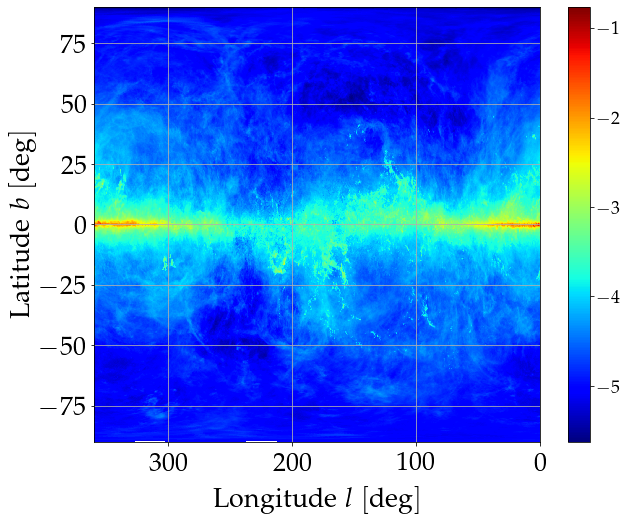

In [18]:
### Block to compute the integrated gamma-ray emission above a certain energy ###


n_ext_HI = len(HI_hdulist)
n_ext_H2 = len(H2_hdulist)
print('n_ext_HI:', n_ext_HI, '; must be equal to len(E)+1 =', En_points + 1)
print('n_ext_H2:', n_ext_H2, '; must be equal to len(E)+1 =', En_points + 1)
print('')
print('nside =', nside)
print('')


npix = healpy.nside2npix(nside)



# Full-sky coordinates
b_min = -90.
b_max = 90.
l_min = 0.
l_max = 360.


theta_min = np.pi/2. - np.radians(b_min)
theta_max = np.pi/2. - np.radians(b_max)
phi_min = np.radians(l_min)
phi_max = np.radians(l_max)


xsize = int(np.sqrt((l_max-l_min)/(b_max-b_min)*npix))
ysize = int((b_max-b_min)/(l_max-l_min)*xsize)
print('npix:', npix)
print('xsize:', xsize)
print('ysize:', ysize)
print('')
print('Delta b / Delta l:', (b_max-b_min)/(l_max-l_min))
print('Delta l / Delta b:', (l_max-l_min)/(b_max-b_min))
print('')

b = np.linspace(b_min, b_max, ysize)
l = np.linspace(l_min, l_max, xsize)
theta = np.linspace(theta_min, theta_max, ysize)
phi   = np.linspace(phi_min, phi_max, xsize)
PHI, THETA = np.meshgrid(phi, theta)
grid_pix = healpy.ang2pix(nside, THETA, PHI)



# We loop over the energies to sum all the fluxes
HI_map_array = np.zeros( (En_points, npix) )
HI_map_tot = np.zeros(npix)
H2_map_array = np.zeros( (En_points, npix) )
H2_map_tot = np.zeros(npix)

for ie in range(En_points):
    
    # HI section
    current_hdu_HI = HI_hdulist[ie+1]
    current_header_HI = current_hdu_HI.header
    current_energy_HI = current_header_HI['ENERGY']
    print('current energy:', current_energy_HI*conv_joule_GeV, 'GeV')
    print('')
    
    HI_map_data = np.array(current_hdu_HI.data)
    HI_map_array[ie, :] = HI_map_data[:]
    
    HI_map_tot[grid_pix] = HI_map_tot[grid_pix] + HI_map_array[ie, grid_pix]
    
    
    # H2 section
    current_hdu_H2 = H2_hdulist[ie+1]
    current_header_H2 = current_hdu_H2.header
    current_energy_H2 = current_header_H2['ENERGY']
    
    H2_map_data = np.array(current_hdu_H2.data)
    H2_map_array[ie, :] = H2_map_data[:]
    
    H2_map_tot[grid_pix] = H2_map_tot[grid_pix] + H2_map_array[ie, grid_pix]
    



fig = plt.figure(figsize=[10,8])

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7


cmap = "jet"


grid_map = H2_map_tot[grid_pix] + HI_map_tot[grid_pix]


image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)
cbar = plt.colorbar(image)

plt.grid(True)

# Plot the longitudinal axis inverted
ax.set_xlim(l_max, l_min)
ax.set_xlabel(r'${\rm Longitude} \; l \; {\rm [deg]}$', fontsize=27, color='k')
ax.set_ylabel(r'${\rm Latitude} \; b \; {\rm [deg]}$', fontsize=27, color='k')


plt.savefig(SkyMapsFolder + 'Pi0_FullSky_cartesian_nside=' + str(nside) + '_Integrated.pdf', dpi=300)  

GeV unit: 1.6021766339999998e-10 in Joule (SI)



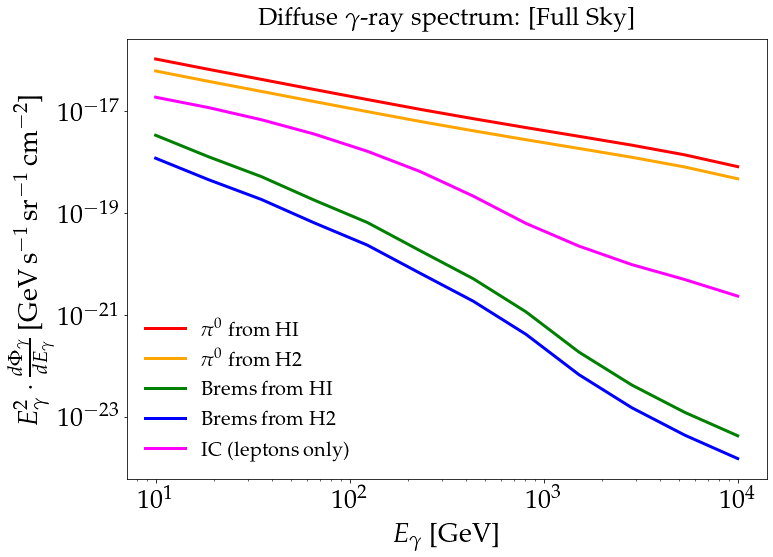

In [19]:
### Block to compute the gamma-ray spectrum ###


use_units = "GeV^-1 cm^-2 s^-1 sr^-1"
skymap_units = u.Quantity(1, use_units)
base_units = skymap_units.unit.si.scale


use_unit = "GeV"
myGeV = u.Quantity(1, use_unit)
GeV_unit = float(myGeV.unit.si.scale)
spectral_units = float(base_units)
print('GeV unit:', GeV_unit, 'in Joule (SI)')
print('')


def rectangular_mask_symmetric(nside, lowb_North, highb_North, lowb_South, highb_South, lowl, highl):
    
    # convert degrees to radians
    lowb_North = lowb_North/180.*np.pi
    lowb_South = lowb_South/180.*np.pi
    lowl= lowl/180.*np.pi
    highb_North = highb_North/180.*np.pi
    highb_South = highb_South/180.*np.pi
    highl= highl/180.*np.pi
    
    npix=12*nside**2
    listpix = np.arange(npix)
    theta,phi = healpy.pixelfunc.pix2ang(nside,listpix, nest=False, lonlat=False)
    
    b = np.pi/2.-theta
    l = phi
    
    mask = []
    for i in np.arange(npix):
         
        if ( (b[i] >= lowb_North and b[i] <= highb_North) or\
             (b[i] >= lowb_South and b[i] <= highb_South) or\
             (b[i] >= lowb_South and b[i] <= highb_North) ) and\
             (l[i] >= lowl and l[i] <= highl):
            mask.append(1)     
        else:
            mask.append(0)
            
    return mask



def calc_mean_flux(hdulist, nside, mask):
    energies = np.asarray([float(hdulist[index+1].header['ENERGY'])/GeV_unit for index in range(n_ext_H2-1)])
    fluxesMatrix = np.zeros(( healpy.nside2npix(nside),n_ext_H2-1))
    
    for index in range(n_ext_H2-1):
        fluxesMatrix[:,index] = np.asarray([hdulist[index+1].data])
    
    fluxes = np.asarray([ np.sum(fluxesMatrix[:,index]*mask[:])/np.sum(mask[:]) for  index in range(n_ext_H2-1)])
    return energies, fluxes


def plot_spectrum(hdulist, label, nside, mask, color):
    energies, fluxes = calc_mean_flux(hdulist, nside, mask)
    plt.plot(energies, fluxes*energies**2/spectral_units, '-', lw='3', label=label, color=color)


fig = plt.figure(figsize=[11,8])
fig.set_tight_layout(True)


newMask = rectangular_mask_symmetric(nside, 0., 90., -90., 0., 0., 360.)


# Plotting section #
plot_spectrum(HI_hdulist, r'$\pi^0$ from HI', nside, newMask, "red")
plot_spectrum(H2_hdulist, r'$\pi^0$ from H2', nside, newMask, "orange")
plot_spectrum(HIBrems_hdulist, r'Brems from HI', nside, newMask, "green")
plot_spectrum(H2Brems_hdulist, r'Brems from H2', nside, newMask, "blue")
plot_spectrum(IC_hdulist, r'IC (leptons only)', nside, newMask, "magenta")


ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7


plt.legend(frameon=False, fontsize = 20)
plt.title("Diffuse $\\gamma$-ray spectrum: [Full Sky]", fontsize=25, pad=15)
plt.xlabel("$E_\gamma$  [GeV]", fontsize=27)
plt.ylabel("$E_\gamma^2 \cdot \\frac{d \Phi_\gamma}{d E_\gamma}$  [" + (skymap_units*u.GeV**2).unit.to_string(format='latex_inline') + "]", fontsize=27)
plt.xscale("log")
plt.yscale("log")


plt.savefig(SkyMapsFolder + 'Diffuse_gamma_emission_FullSky_nside=' + str(nside) + '.pdf', dpi=150)    